# Bowel Segmentation using SegFormer

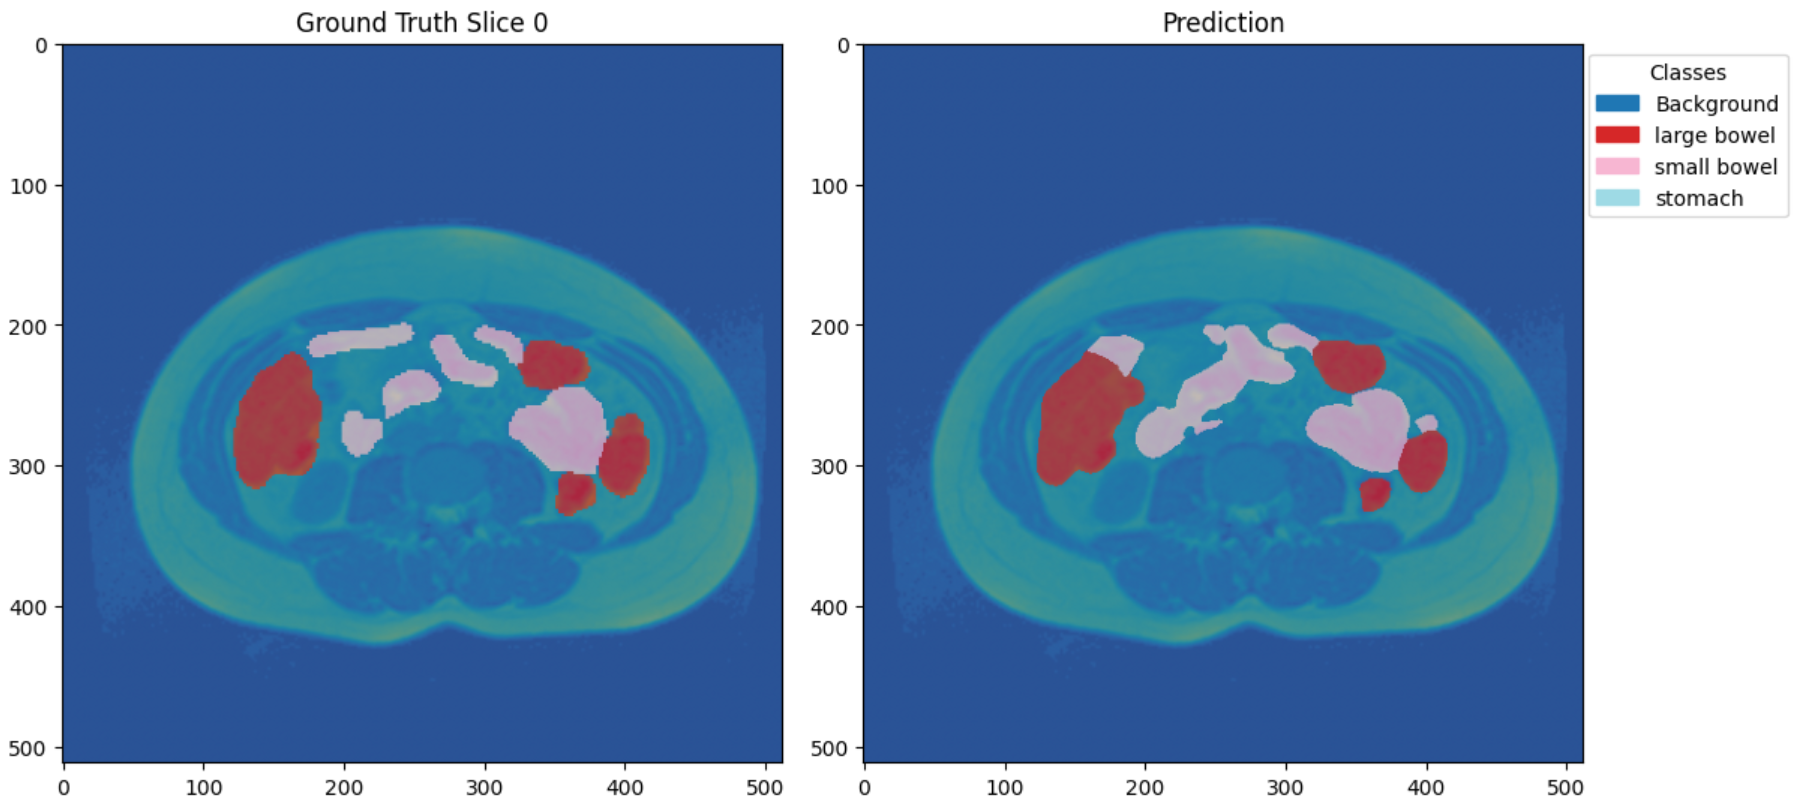

In [52]:
# Imports
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import SegformerForSemanticSegmentation, SegformerImageProcessor
import numpy as np
import os
from tqdm import tqdm
import albumentations as A
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import CosineAnnealingLR
import torch.nn.functional as F
from ipywidgets import interactive
import kagglehub
import pandas as pd
import cv2
from matplotlib.patches import Patch
from matplotlib.colors import BoundaryNorm
import SimpleITK as sitk
import ants
from torchvision.transforms.functional import to_pil_image
from sklearn.model_selection import train_test_split

## Load Dataset from kagglehub

In [53]:
path = kagglehub.dataset_download("happyharrycn/uw-madison-gi-tract-image-segmentation-dataset")

Using Colab cache for faster access to the 'uw-madison-gi-tract-image-segmentation-dataset' dataset.


### Dataset utitlities

In [54]:
# hand coded color scheme for visualization (order RGB)
default_color_dict = {0 : (255/255., 102/255., 102/255.), #'ampulla_of_vater'
                      1 : (255/255., 178/255., 102/255.), #'large_bowel'
                      2 : (102/255., 255/255., 102/255.), #'pyloric_sphincter'
                      3 : (102/255., 255/255., 255/255.), #'small_bowel'
                      4 : (178/255., 102/255., 255/255.)} #'stomach'
# reference dict for mask type
mask_dict = {0 : 'ampulla of vater',
             1 : 'large bowel',
             2 : 'pyloric sphincter',
             3 : 'small bowel',
             4 : 'stomach'}

def process_image(img):
    gamma = 0.6
    img = img.astype(np.float32)
    img = img ** gamma
    if np.max(img) == 0:
        return np.zeros_like(img)
    else:
        img = img / np.max(img)
    return img

def rle_decode(mask_rle, shape, dtype=np.uint8):
    '''
    Helper function for run-length decoding
    ref.: https://www.kaggle.com/stainsby/fast-tested-rle
    Inputs:
        mask_rle: string formated RLE
        shape: (height,width) of array to return
        dtype: data type of array to return (default: uint8)
    Returns
        numpy array, 1 - mask, 0 - background
    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=dtype)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape)



### Utitly Functions

In [55]:
def verify_scan_path(scans_path, contours_path):
    """
    Verifies if there are valid (non-blank) scans present.
    Returns True if valid scans exist, False otherwise.
    """
    df_full = pd.read_csv(contours_path)
    cum_mean = 0
    file_count = 0

    for root, dirs, files in os.walk(scans_path):
        files = [f for f in files if f.endswith(('.png', '.jpg', '.jpeg', '.tif'))]

        if not files:
            continue

        for file in files:
            img = cv2.imread(os.path.join(root, file), 0)
            if img is None:
                continue

            img = process_image(img)

            if img.mean() < 0.1:
                continue

            slice_id = file[:10]
            df = df_full[df_full['SliceID'] == slice_id]

            if df.empty:
                continue

            if all(str(ep) in ['-1', '', 'nan'] for ep in df['EncodedPixels']):
                continue

            cum_mean += img.mean()
            file_count += 1

    # Use average mean per valid file instead of cumulative sum
    if file_count > 0:
        avg_mean = cum_mean / file_count
        # print(avg_mean)
        return bool(avg_mean > 0.1)
    return False

def calculate_class_weights(contours_path, class_dict):
    """
    Calculates class weights based on the frequency of each class in the dataset.
    Returns a dictionary with class IDs as keys and their corresponding weights as values."""

    # Read CSV once outside the loop
    df_full = pd.read_csv(contours_path)

    slice_ids = df_full['SliceID'].unique()

    for slice_id in slice_ids:
        df = df_full[df_full['SliceID'] == slice_id]
        if df.empty:
            continue
        mask_type_ids = df[df['EncodedPixels']!='-1']['MaskTypeID']
        for mask_type_id in mask_type_ids:
            if mask_type_id in class_dict:
                class_dict[mask_type_id] += 1
            else:
                class_dict[mask_type_id] = 1

    return class_dict

def get_augmentation_pipeline(is_train=True, img_size=512):
    """
    Creates augmentation pipeline for training or validation
    """
    if is_train:
        transform = A.Compose([
            A.Resize(img_size, img_size),
            A.HorizontalFlip(p=0.5),
            A.ShiftScaleRotate(
                shift_limit=0.05,
                scale_limit=0.1,
                rotate_limit=10,
                border_mode=0,
                p=0.5
            ),
            A.ElasticTransform(alpha=50, sigma=5, p=0.3),
            A.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1, p=0.3),
        ])
    else:
        transform = A.Compose([
            A.Resize(img_size, img_size),
        ])

    return transform

## Train test split

In [56]:
# base_path to the dataset
base_path = os.path.join(path , 'dataset')
samples = []
# load the path to each scan for the patients
for root, dirs, files in os.walk(base_path):
    if 'contours' in root:
       samples.append(os.path.dirname(root))
train_images, test_images = train_test_split(samples, test_size=0.1, random_state=101)

### Validate train image paths

In [ ]:
# only keep the valid samples
sample_sets = set(train_images)
temp_samples_set = sample_sets.copy()
loader = tqdm(total=len(temp_samples_set))
for sample in temp_samples_set:
    scans_path = os.path.join(sample, "scans" )
    contours_path = os.path.join(sample, "contours", "masks_rle.csv")
    if not verify_scan_path(scans_path, contours_path):
        sample_sets.remove(sample)
    loader.update(1)

# only keep the samples which have a mask
train_images_paths = []
verified_samples = list(sample_sets)
for path in verified_samples:

    tail = os.path.split(path)[1]
    parent = os.path.split(os.path.dirname(path))[1]
    scans_dir = os.path.join(parent, tail, 'scans')
    contours_dir = os.path.join(path, 'contours', 'masks_rle.csv')
    image_file_names_temp = [os.path.join(scans_dir, f) for f in os.listdir(os.path.join(path, 'scans')) if '.png' in f]
    image_file_names_temp_set = set(image_file_names_temp)
    for img_path in image_file_names_temp:
        slice_id = os.path.split(img_path)[1][:10]
        df = pd.read_csv(contours_dir)
        df = df[df['SliceID'] == slice_id]
        if df.empty or all(str(ep) in ['-1', '', 'nan'] for ep in df['EncodedPixels']):
            image_file_names_temp_set.remove(img_path)

    train_images_paths.extend(list(image_file_names_temp_set))



100%|██████████| 420/420 [04:14<00:00,  1.58it/s]

### Per class counts and class weights calculation for train-set

In [ ]:
loader = tqdm(total=len(sample_sets))
class_dict = {}
for sample in sample_sets:
    contours_path = os.path.join(sample, "contours", "masks_rle.csv")
    class_dict = calculate_class_weights(contours_path, class_dict)
    loader.update(1)
class_counts = dict(sorted(class_dict.items(), key=lambda x: x[0]))

# Remove Minority Classes
del class_counts[0]
del class_counts[2]

class_weights = np.array(list(class_counts.values())).mean()/np.array(list(class_counts.values()))

In [ ]:
class_weights

array([0.81251513, 1.01920595, 1.26887818])

### Validate test image paths

In [ ]:
# only keep the test samples
sample_sets = set(test_images)
temp_samples_set = sample_sets.copy()
loader = tqdm(total=len(temp_samples_set))
for sample in temp_samples_set:
    scans_path = os.path.join(sample, "scans" )
    contours_path = os.path.join(sample, "contours", "masks_rle.csv")
    if not verify_scan_path(scans_path, contours_path):
        sample_sets.remove(sample)
    loader.update(1)

# only keep the samples which have a mask
test_image_paths = []
verified_samples = list(sample_sets)
for path in verified_samples:

    tail = os.path.split(path)[1]
    parent = os.path.split(os.path.dirname(path))[1]
    scans_dir = os.path.join(parent, tail, 'scans')
    contours_dir = os.path.join(path, 'contours', 'masks_rle.csv')
    image_file_names_temp = [os.path.join(scans_dir, f) for f in os.listdir(os.path.join(path, 'scans')) if '.png' in f]
    image_file_names_temp_set = set(image_file_names_temp)
    for img_path in image_file_names_temp:
        slice_id = os.path.split(img_path)[1][:10]
        df = pd.read_csv(contours_dir)
        df = df[df['SliceID'] == slice_id]
        if df.empty or all(str(ep) in ['-1', '', 'nan'] for ep in df['EncodedPixels']):
            image_file_names_temp_set.remove(img_path)

    test_image_paths.extend(list(image_file_names_temp_set))



100%|██████████| 47/47 [00:37<00:00,  1.11it/s]

### Dataset class

In [59]:

# Custom Dataset Class for Semantic Segmentation
class BowelSegmentationDataset(Dataset):
    def __init__(self, root_dir, image_paths, processor, transform=None, num_classes=21):
        self.root_dir = root_dir
        self.image_paths = image_paths
        self.processor = processor
        self.transform = transform
        self.num_classes = num_classes

    def __len__(self):
        return len(self.image_paths)

    def apply_denoise(self, raw_scans):
      """ Denoise MRI using ANTs Denoising """
      mri_image_vector = raw_scans
      raw_image_ants = ants.from_numpy(mri_image_vector)
      denoised_mri_ants = ants.denoise_image(raw_image_ants)
      denoised_mri = denoised_mri_ants.numpy()
      return denoised_mri

    def apply_bias_correction(self, denoised_mri):
      """ Apply N4 Bias Field Correction using SimpleITK """
      mri_data = sitk.GetImageFromArray(denoised_mri)
      transformed = sitk.RescaleIntensity(mri_data, 0, 255)
      msk = sitk.LiThreshold(transformed,0,1)
      shrink_factor = 3
      input_image = sitk.Shrink(mri_data, [shrink_factor]*mri_data.GetDimension())
      msk_image = sitk.Shrink(msk, [shrink_factor]*msk.GetDimension())
      bfc = sitk.N4BiasFieldCorrectionImageFilter()
      corrected = bfc.Execute(mri_data, msk)
      bias_field_corrected = bfc.GetLogBiasFieldAsImage(mri_data)
      full_resolution_corrected = mri_data/sitk.Exp(bias_field_corrected)
      mri_corrected = sitk.GetArrayFromImage(full_resolution_corrected)
      return mri_corrected

    def load_depth_images(self,path1, path2):
      """ Load and process depth images """
      depth_img1 = cv2.imread(path1, 0)
      depth_img2 = cv2.imread(path2, 0)
      depth_img1 = process_image(depth_img1)
      depth_img2 = process_image(depth_img2)
      return depth_img1, depth_img2

    def preprocess_image(self, img, idx):
      """ Preprocess image with denoising and bias correction using neighboring slices """
      if idx==0:
        depth_img_path1 = os.path.join(self.root_dir, self.image_paths[idx+1])
        depth_img_path2 = os.path.join(self.root_dir, self.image_paths[idx+2])
        depth_img1, depth_img2 = self.load_depth_images(depth_img_path1, depth_img_path2)
        raw_scans = np.stack([img.astype('float32'),depth_img1.astype('float32'), depth_img2.astype('float32')], axis=0)
        denoised_mri = self.apply_denoise(raw_scans)
        mri_corrected = self.apply_bias_correction(denoised_mri)
        img = mri_corrected[0,:,:]
      elif idx==len(self.image_paths)-1:
        depth_img_path1 = os.path.join(self.root_dir, self.image_paths[idx-1])
        depth_img_path2 = os.path.join(self.root_dir, self.image_paths[idx-2])
        depth_img1, depth_img2 = self.load_depth_images(depth_img_path1, depth_img_path2)
        raw_scans = np.stack([depth_img1.astype('float32'), depth_img2.astype('float32'),img.astype('float32')], axis=0)
        denoised_mri = self.apply_denoise(raw_scans)
        mri_corrected = self.apply_bias_correction(denoised_mri)
        img = mri_corrected[2,:,:]
      else:
        depth_img_path1 = os.path.join(self.root_dir, self.image_paths[idx-1])
        depth_img_path2 = os.path.join(self.root_dir, self.image_paths[idx+1])
        depth_img1, depth_img2 = self.load_depth_images(depth_img_path1, depth_img_path2)
        raw_scans = np.stack([depth_img1.astype('float32'), img.astype('float32'), depth_img2.astype('float32')], axis=0)
        denoised_mri = self.apply_denoise( raw_scans)
        mri_corrected = self.apply_bias_correction(denoised_mri)
        img = mri_corrected[1,:,:]
      return img

    def __getitem__(self, idx):
      """ Get item method to load image and corresponding mask """
      # Removing 0 and 2
      KEEP_CLASSES = [1, 3, 4]
      CLASS_REMAP = {old: new for new, old in enumerate(sorted(KEEP_CLASSES))}
      REMOVE_CLASSES = [0, 2]

      img_path = self.image_paths[idx]
      img_path = os.path.join(self.root_dir, img_path)

      slice_id = os.path.split(self.image_paths[idx])[1][:10]
      contour_mask_path = os.path.split(os.path.split(self.image_paths[idx])[0])[0]
      contour_mask_path = os.path.join(contour_mask_path, 'contours', 'masks_rle.csv')
      contours_path = os.path.join(self.root_dir, contour_mask_path)
      # Load image
      img = cv2.imread(img_path, 0)
      img = process_image(img)

      img = self.preprocess_image(img, idx)

      # Get mask
      df = pd.read_csv(contours_path)
      df = df[df['SliceID'] == slice_id]
      df = df[~df['MaskTypeID'].isin(REMOVE_CLASSES)]
      h, w = img.shape
      mask = np.zeros((h, w), dtype=np.int64)
      for _, row in df.iterrows():
          mask_rle = row['EncodedPixels']
          mask_type = row['MaskTypeID']

          if str(mask_rle) not in ['-1', '', 'nan', 'None']:
              decoded = rle_decode(mask_rle, shape=(h, w), dtype=np.float32)
              mask[decoded == 1] = CLASS_REMAP[mask_type] + 1

      if self.transform:
          augmented = self.transform(image=img, mask=mask)
          img = augmented['image']
          mask = augmented['mask']
      img = np.expand_dims(img, axis=0)
      img = np.repeat(img, 3, axis=0)  # (3, 266, 266)
      img = np.transpose(img, (1, 2, 0))
      # plt.imshow(img)
      encoded = self.processor(images=img, segmentation_maps=mask, return_tensors="pt")

      # Remove batch dimension
      for k, v in encoded.items():
          encoded[k] = v.squeeze(0)
      # dict with 'pixel_values' and 'labels'
      return encoded



## Custom Loss Function

In [ ]:
class CombinedLoss(nn.Module):
    def __init__(self, weights=None):
        super().__init__()
        self.ce = nn.CrossEntropyLoss(weight=weights)

    def dice_loss(self, pred, target, num_classes=4):
        """Computes the Dice loss, excluding the background class."""
        pred_soft = torch.softmax(pred, dim=1)
        target_oh = F.one_hot(target, num_classes).permute(0, 3, 1, 2).float()

        intersection = (pred_soft * target_oh).sum(dim=(2, 3))
        union = pred_soft.sum(dim=(2, 3)) + target_oh.sum(dim=(2, 3))

        dice = (2 * intersection + 1e-6) / (union + 1e-6)
        return 1 - dice[:, 1:].mean()  # Exclude background

    def forward(self, pred, target):
        return self.ce(pred, target) + self.dice_loss(pred, target)

## Model Trainer

In [ ]:
# Training Function
class SegFormerTrainer:
    def __init__(self, model, train_loader, val_loader, device, num_classes, optimizer=None, scheduler=None, start_epoch=0, best_iou=0.0):
        self.model = model
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.device = device
        self.num_classes = num_classes
        self.start_epoch=start_epoch
        self.best_iou = best_iou

        # weights = torch.FloatTensor([0.81251513, 1.01920595, 1.26887818])
        weights = torch.FloatTensor([0.81251513, 2.0, 1.26887818])
        weights = torch.cat([torch.tensor([0.3]), weights]).to(device)
        print("class weights applied: ", weights)
        self.criterion = CombinedLoss(weights=weights)

        # Optimizer
        if optimizer is None:
          self.optimizer = torch.optim.AdamW([
      {"params": model.segformer.encoder.parameters(), "lr": 1e-5},
      {"params": model.decode_head.parameters(), "lr": 1e-4},
  ], weight_decay=0.01)
        else:
          self.optimizer = optimizer

        # Learning rate scheduler
        if scheduler is None:
          self.scheduler = CosineAnnealingLR(
              self.optimizer,
              T_max=len(train_loader) * 200,
              eta_min=1e-6
          )
        else:
          self.scheduler = scheduler

        self.train_losses = []
        self.val_losses = []
        self.val_ious = []

    def compute_iou(self, preds, labels):
        """Compute IoU metric for semantic segmentation"""
        ious = []
        preds = preds.view(-1)
        labels = labels.view(-1)

        for cls in range(self.num_classes):
            pred_cls = preds == cls
            label_cls = labels == cls

            intersection = (pred_cls & label_cls).float().sum()
            union = (pred_cls | label_cls).float().sum()

            if union == 0:
                ious.append(float('nan'))
            else:
                ious.append((intersection / union).item())

        return np.nanmean(ious)

    def train_epoch(self):
        self.model.train()
        total_loss = 0
        progress_bar = tqdm(self.train_loader, desc="Training")

        for batch_idx, batch in enumerate(progress_bar):
            inputs = {k: v.to(self.device) for k, v in batch.items() if k != 'labels'}
            masks = batch['labels'].to(self.device)
            # Forward pass
            outputs = self.model(**inputs)
            logits = outputs.logits

            # Upsample logits to match mask size
            upsampled_logits = nn.functional.interpolate(
                logits,
                size=masks.shape[-2:],
                mode="bilinear",
                align_corners=False
            )

            # Calculate loss
            loss = self.criterion(upsampled_logits, masks)

            # Backward pass
            self.optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), 1.0)
            self.optimizer.step()
            self.scheduler.step()

            total_loss += loss.item()
            progress_bar.set_postfix({'loss': loss.item()})

        return total_loss / len(self.train_loader)

    def validate(self):
        self.model.eval()
        total_loss = 0
        total_iou = 0

        with torch.no_grad():
            progress_bar = tqdm(self.val_loader, desc="Validation")
            for batch_idx, batch in enumerate(progress_bar):
              inputs = {k: v.to(self.device) for k, v in batch.items() if k != 'labels'}
              masks = batch['labels'].to(self.device)
              outputs = self.model(**inputs)
              logits = outputs.logits

              upsampled_logits = nn.functional.interpolate(
                  logits,
                  size=masks.shape[-2:],
                  mode="bilinear",
                  align_corners=False
              )

              loss = self.criterion(upsampled_logits, masks)
              total_loss += loss.item()

              # Compute IoU
              preds = upsampled_logits.argmax(dim=1)
              iou = self.compute_iou(preds, masks)
              total_iou += iou

              progress_bar.set_postfix({'loss': loss.item(), 'IoU': iou})

        avg_loss = total_loss / len(self.val_loader)
        avg_iou = total_iou / len(self.val_loader)

        return avg_loss, avg_iou

    def train(self, num_epochs):
        best_iou = self.best_iou
        patience= 10
        patience_counter=0
        best_state=None
        for epoch in range(self.start_epoch, num_epochs):
            print(f"\nEpoch {epoch+1}/{num_epochs}")

            # Training
            train_loss = self.train_epoch()
            self.train_losses.append(train_loss)

            # Validation
            val_loss, val_iou = self.validate()
            self.val_losses.append(val_loss)
            self.val_ious.append(val_iou)

            print(f"Train Loss: {train_loss:.4f}")
            print(f"Val Loss: {val_loss:.4f}, Val IoU: {val_iou:.4f}, Best IoU: {best_iou:.4f}")

            # Save best model
            if val_iou > best_iou:
                best_iou = val_iou
                patience_counter = 0
                best_state = self.model.state_dict()
                torch.save({
                    'epoch': epoch,
                    'model_state_dict': best_state,
                    'optimizer_state_dict': self.optimizer.state_dict(),
                    "scheduler": self.scheduler.state_dict(),
                    'best_iou': best_iou,
                }, "/content/drive/MyDrive/bowseg_t3.pth")
                print(f"Saved best model with IoU: {best_iou:.4f}")
            else:
              patience_counter+=1
              if patience_counter>=patience:
                print(f"Convered at Epoch: {epoch},IoU: {best_iou:.4f}")
                if best_state is not None:
                  self.model.load_state_dict(best_state)
                break

## Model and Data Init

In [ ]:

BATCH_SIZE = 32
NUM_EPOCHS = 30
NUM_CLASSES = 4  # Change based on your dataset
IMG_SIZE = 512
MODEL_NAME = "nvidia/segformer-b0-finetuned-ade-512-512"  # You can use b0-b5

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Initialize processor and model
processor = SegformerImageProcessor.from_pretrained(MODEL_NAME, do_rescale=False)
model = SegformerForSemanticSegmentation.from_pretrained(
    MODEL_NAME,
    num_labels=NUM_CLASSES,
    ignore_mismatched_sizes=True
)
model = model.to(device)



# Create datasets
train_dataset = BowelSegmentationDataset(
    root_dir= base_path,
    image_paths = train_images_paths,
    processor=processor,
    transform=get_augmentation_pipeline(is_train=True, img_size=IMG_SIZE),
    num_classes=NUM_CLASSES
)

val_dataset = BowelSegmentationDataset(
    root_dir= base_path,
    image_paths = test_image_paths,
    processor=processor,
    transform=get_augmentation_pipeline(is_train=False, img_size=IMG_SIZE),
    num_classes=NUM_CLASSES
)

# Create data loaders
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2,
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)


Using device: cpu


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/271 [00:00<?, ?B/s]

/usr/local/lib/python3.12/dist-packages/transformers/image_processing_base.py:417: UserWarning: The following named arguments are not valid for `SegformerImageProcessor.__init__` and were ignored: 'feature_extractor_type', 'reduce_labels'
  image_processor = cls(**image_processor_dict)


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/15.0M [00:00<?, ?B/s]

Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/segformer-b0-finetuned-ade-512-512 and are newly initialized because the shapes did not match:
- decode_head.classifier.bias: found shape torch.Size([150]) in the checkpoint and torch.Size([4]) in the model instantiated
- decode_head.classifier.weight: found shape torch.Size([150, 256, 1, 1]) in the checkpoint and torch.Size([4, 256, 1, 1]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.12/dist-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


### Lengths

In [ ]:
len(train_loader), len(train_dataset), len(val_loader), len(val_dataset)

(620, 19825, 64, 2036)

#### Train input and mask


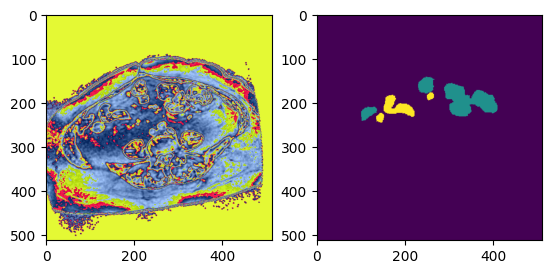

In [64]:

plt.subplot(121)
plt.imshow(to_pil_image(train_dataset[0]['pixel_values']))
plt.subplot(122)
plt.imshow(train_dataset[0]['labels'])

## Model Utilities

In [ ]:
def load_checkpoint(model, train_loader):
    """Load model, optimizer, and scheduler states from checkpoint"""
    states = torch.load("/content/drive/MyDrive/bowseg_t3.pth",
                        map_location="cuda", weights_only=False )

    device = torch.device("cuda")

    # Load model weights
    model.load_state_dict(states["model_state_dict"])

    # Create optimizer AFTER model is on CUDA
    optimizer = torch.optim.AdamW([
        {"params": model.segformer.encoder.parameters(), "lr": 1e-5},
        {"params": model.decode_head.parameters(), "lr": 1e-4},
    ], weight_decay=0.01)
    # Load optimizer state
    optimizer.load_state_dict(states["optimizer_state_dict"])
    for state in optimizer.state.values():
        for k, v in state.items():
            if torch.is_tensor(v):
                state[k] = v.to(device)

    # Create scheduler
    scheduler = CosineAnnealingLR(
                optimizer,
                T_max=len(train_loader) * 200,  # 60 epochs
                eta_min=1e-6
            )

    # Load scheduler state
    scheduler.load_state_dict(states["scheduler"])
    start_epoch = states["epoch"] + 1
    best_iou = states["best_iou"]
    return model, optimizer, scheduler, start_epoch, best_iou


## Finetuning

In [ ]:
model

SegformerForSemanticSegmentation(
  (segformer): SegformerModel(
    (encoder): SegformerEncoder(
      (patch_embeddings): ModuleList(
        (0): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(3, 32, kernel_size=(7, 7), stride=(4, 4), padding=(3, 3))
          (layer_norm): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
        )
        (1): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (layer_norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        )
        (2): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(64, 160, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (layer_norm): LayerNorm((160,), eps=1e-05, elementwise_affine=True)
        )
        (3): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(160, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
  

# Finetuning Start

In [ ]:
# Initialize trainer
trainer = SegFormerTrainer(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    device=device,
    num_classes=NUM_CLASSES
)

# Train model
trainer.train(num_epochs=200)

print("Training completed!")

class weights applied:  tensor([0.3000, 0.8125, 2.0000, 1.2689], device='cuda:0')

Epoch 1/200


Validation: 100%|██████████| 64/64 [01:21<00:00,  1.27s/it, loss=0.871, IoU=0.537]


Train Loss: 1.1477
Val Loss: 0.8257, Val IoU: 0.5820, Best IoU: 0.0000
Saved best model with IoU: 0.5820

Epoch 2/200


Validation: 100%|██████████| 64/64 [01:22<00:00,  1.29s/it, loss=0.825, IoU=0.566]


Train Loss: 0.8149
Val Loss: 0.7508, Val IoU: 0.6145, Best IoU: 0.5820
Saved best model with IoU: 0.6145

Epoch 3/200


Validation: 100%|██████████| 64/64 [01:45<00:00,  1.65s/it, loss=0.807, IoU=0.595]


Train Loss: 0.7603
Val Loss: 0.7186, Val IoU: 0.6426, Best IoU: 0.6145
Saved best model with IoU: 0.6426

Epoch 4/200


Training:   0%|          | 0/620 [00:02<?, ?it/s]


KeyboardInterrupt: 

### Load Best model


In [ ]:
model, optimizer, scheduler, start_epoch, best_iou = load_checkpoint(model, train_loader)

#### Resume training from epoch 4

In [ ]:
# Initialize trainer
trainer = SegFormerTrainer(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    device=device,
    num_classes=NUM_CLASSES,
    optimizer=optimizer,
    scheduler=scheduler,
    start_epoch=start_epoch,
    best_iou=best_iou
)

# Train model
trainer.train(num_epochs=200)

print("Training completed!")

class weights applied:  tensor([0.3000, 0.8125, 2.0000, 1.2689], device='cuda:0')

Epoch 4/200


Validation: 100%|██████████| 64/64 [01:22<00:00,  1.30s/it, loss=0.775, IoU=0.625]


Train Loss: 0.7290
Val Loss: 0.6929, Val IoU: 0.6583, Best IoU: 0.6426
Saved best model with IoU: 0.6583

Epoch 5/200


Validation: 100%|██████████| 64/64 [01:20<00:00,  1.26s/it, loss=0.775, IoU=0.631]


Train Loss: 0.7083
Val Loss: 0.6841, Val IoU: 0.6649, Best IoU: 0.6583
Saved best model with IoU: 0.6649

Epoch 6/200


Validation: 100%|██████████| 64/64 [01:19<00:00,  1.23s/it, loss=0.769, IoU=0.639]


Train Loss: 0.6936
Val Loss: 0.6701, Val IoU: 0.6802, Best IoU: 0.6649
Saved best model with IoU: 0.6802

Epoch 7/200


Training:  15%|█▌        | 96/620 [03:11<17:42,  2.03s/it, loss=0.768]

### Resume training from epoch 7

In [ ]:
model, optimizer, scheduler, start_epoch, best_iou = load_checkpoint(model, train_loader)
trainer = SegFormerTrainer(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    device=device,
    num_classes=NUM_CLASSES,
    optimizer=optimizer,
    scheduler=scheduler,
    start_epoch=start_epoch,
    best_iou=best_iou
)

# Train model
trainer.train(num_epochs=200)

print("Training completed!")

class weights applied:  tensor([0.3000, 0.8125, 2.0000, 1.2689], device='cuda:0')

Epoch 7/200


Validation: 100%|██████████| 64/64 [01:24<00:00,  1.33s/it, loss=0.755, IoU=0.651]


Train Loss: 0.6821
Val Loss: 0.6640, Val IoU: 0.6824, Best IoU: 0.6802
Saved best model with IoU: 0.6824

Epoch 8/200


Validation: 100%|██████████| 64/64 [01:19<00:00,  1.24s/it, loss=0.741, IoU=0.657]


Train Loss: 0.6733
Val Loss: 0.6567, Val IoU: 0.6862, Best IoU: 0.6824
Saved best model with IoU: 0.6862

Epoch 9/200


Validation: 100%|██████████| 64/64 [01:19<00:00,  1.24s/it, loss=0.756, IoU=0.655]


Train Loss: 0.6656
Val Loss: 0.6523, Val IoU: 0.6902, Best IoU: 0.6862
Saved best model with IoU: 0.6902

Epoch 10/200


Validation: 100%|██████████| 64/64 [01:20<00:00,  1.25s/it, loss=0.759, IoU=0.655]


Train Loss: 0.6586
Val Loss: 0.6499, Val IoU: 0.6948, Best IoU: 0.6902
Saved best model with IoU: 0.6948

Epoch 11/200


Validation: 100%|██████████| 64/64 [01:21<00:00,  1.27s/it, loss=0.748, IoU=0.66]


Train Loss: 0.6534
Val Loss: 0.6427, Val IoU: 0.6952, Best IoU: 0.6948
Saved best model with IoU: 0.6952

Epoch 12/200


Validation: 100%|██████████| 64/64 [01:22<00:00,  1.29s/it, loss=0.746, IoU=0.664]


Train Loss: 0.6487
Val Loss: 0.6398, Val IoU: 0.7016, Best IoU: 0.6952
Saved best model with IoU: 0.7016

Epoch 13/200


Validation: 100%|██████████| 64/64 [01:20<00:00,  1.26s/it, loss=0.735, IoU=0.668]


Train Loss: 0.6461
Val Loss: 0.6383, Val IoU: 0.7038, Best IoU: 0.7016
Saved best model with IoU: 0.7038

Epoch 14/200


Validation: 100%|██████████| 64/64 [01:22<00:00,  1.29s/it, loss=0.754, IoU=0.662]


Train Loss: 0.6428
Val Loss: 0.6373, Val IoU: 0.7074, Best IoU: 0.7038
Saved best model with IoU: 0.7074

Epoch 15/200


Validation: 100%|██████████| 64/64 [01:19<00:00,  1.24s/it, loss=0.747, IoU=0.665]


Train Loss: 0.6407
Val Loss: 0.6349, Val IoU: 0.7070, Best IoU: 0.7074

Epoch 16/200


Validation: 100%|██████████| 64/64 [01:19<00:00,  1.24s/it, loss=0.743, IoU=0.667]


Train Loss: 0.6387
Val Loss: 0.6355, Val IoU: 0.7053, Best IoU: 0.7074

Epoch 17/200


Training:  71%|███████   | 438/620 [14:15<05:54,  1.95s/it, loss=0.625]

### Resume training from epoch 15

In [ ]:
model, optimizer, scheduler, start_epoch, best_iou = load_checkpoint(model, train_loader)
trainer = SegFormerTrainer(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    device=device,
    num_classes=NUM_CLASSES,
    optimizer=optimizer,
    scheduler=scheduler,
    start_epoch=start_epoch,
    best_iou=best_iou
)

# Train model
trainer.train(num_epochs=200)

print("Training completed!")

class weights applied:  tensor([0.3000, 0.8125, 2.0000, 1.2689], device='cuda:0')

Epoch 15/200


Validation: 100%|██████████| 64/64 [01:29<00:00,  1.40s/it, loss=0.752, IoU=0.665]


Train Loss: 0.6408
Val Loss: 0.6366, Val IoU: 0.7059, Best IoU: 0.7074

Epoch 16/200


Validation: 100%|██████████| 64/64 [01:24<00:00,  1.32s/it, loss=0.739, IoU=0.669]


Train Loss: 0.6389
Val Loss: 0.6330, Val IoU: 0.7068, Best IoU: 0.7074

Epoch 17/200


Validation: 100%|██████████| 64/64 [01:23<00:00,  1.30s/it, loss=0.748, IoU=0.668]


Train Loss: 0.6373
Val Loss: 0.6329, Val IoU: 0.7085, Best IoU: 0.7074
Saved best model with IoU: 0.7085

Epoch 18/200


Validation: 100%|██████████| 64/64 [01:21<00:00,  1.27s/it, loss=0.749, IoU=0.669]


Train Loss: 0.6361
Val Loss: 0.6341, Val IoU: 0.7091, Best IoU: 0.7085
Saved best model with IoU: 0.7091

Epoch 19/200


Validation: 100%|██████████| 64/64 [01:21<00:00,  1.28s/it, loss=0.746, IoU=0.67]


Train Loss: 0.6351
Val Loss: 0.6323, Val IoU: 0.7088, Best IoU: 0.7091

Epoch 20/200


Validation: 100%|██████████| 64/64 [01:24<00:00,  1.32s/it, loss=0.743, IoU=0.67]


Train Loss: 0.6346
Val Loss: 0.6324, Val IoU: 0.7077, Best IoU: 0.7091

Epoch 21/200


Validation: 100%|██████████| 64/64 [01:23<00:00,  1.30s/it, loss=0.745, IoU=0.669]


Train Loss: 0.6339
Val Loss: 0.6322, Val IoU: 0.7083, Best IoU: 0.7091

Epoch 22/200


Validation: 100%|██████████| 64/64 [01:24<00:00,  1.32s/it, loss=0.738, IoU=0.673]


Train Loss: 0.6330
Val Loss: 0.6309, Val IoU: 0.7096, Best IoU: 0.7091
Saved best model with IoU: 0.7096

Epoch 23/200


Training:  34%|███▍      | 213/620 [07:32<14:23,  2.12s/it, loss=0.639]


KeyboardInterrupt: 

### Resume training from epoch 23, with increased class weight for class 2

In [ ]:
model, optimizer, scheduler, start_epoch, best_iou = load_checkpoint(model, train_loader)
trainer = SegFormerTrainer(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    device=device,
    num_classes=NUM_CLASSES,
    optimizer=optimizer,
    scheduler=scheduler,
    start_epoch=start_epoch,
    best_iou=best_iou
)

# Train model
trainer.train(num_epochs=200)

print("Training completed!")

class weights applied:  tensor([0.3000, 0.8125, 2.0000, 1.2689], device='cuda:0')

Epoch 23/200


Validation: 100%|██████████| 64/64 [01:34<00:00,  1.47s/it, loss=0.743, IoU=0.672]


Train Loss: 0.6330
Val Loss: 0.6321, Val IoU: 0.7096, Best IoU: 0.7096
Saved best model with IoU: 0.7096

Epoch 24/200


Validation: 100%|██████████| 64/64 [01:27<00:00,  1.36s/it, loss=0.742, IoU=0.672]


Train Loss: 0.6319
Val Loss: 0.6315, Val IoU: 0.7103, Best IoU: 0.7096
Saved best model with IoU: 0.7103

Epoch 25/200


Validation: 100%|██████████| 64/64 [01:27<00:00,  1.37s/it, loss=0.745, IoU=0.672]


Train Loss: 0.6303
Val Loss: 0.6295, Val IoU: 0.7112, Best IoU: 0.7103
Saved best model with IoU: 0.7112

Epoch 26/200


Validation:  25%|██▌       | 16/64 [00:23<01:06,  1.38s/it, loss=0.567, IoU=0.734]

### Resume training from epoch 26

In [ ]:
model, optimizer, scheduler, start_epoch, best_iou = load_checkpoint(model, train_loader)
trainer = SegFormerTrainer(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    device=device,
    num_classes=NUM_CLASSES,
    optimizer=optimizer,
    scheduler=scheduler,
    start_epoch=start_epoch,
    best_iou=best_iou
)

# Train model
trainer.train(num_epochs=200)

print("Training completed!")

class weights applied:  tensor([0.3000, 0.8125, 2.0000, 1.2689], device='cuda:0')

Epoch 26/200


Validation: 100%|██████████| 64/64 [01:27<00:00,  1.36s/it, loss=0.744, IoU=0.671]


Train Loss: 0.6299
Val Loss: 0.6310, Val IoU: 0.7106, Best IoU: 0.7112

Epoch 27/200


Validation: 100%|██████████| 64/64 [01:20<00:00,  1.26s/it, loss=0.755, IoU=0.671]


Train Loss: 0.6284
Val Loss: 0.6299, Val IoU: 0.7145, Best IoU: 0.7112
Saved best model with IoU: 0.7145

Epoch 28/200


Validation: 100%|██████████| 64/64 [01:19<00:00,  1.23s/it, loss=0.729, IoU=0.676]


Train Loss: 0.6277
Val Loss: 0.6261, Val IoU: 0.7125, Best IoU: 0.7145

Epoch 29/200


Validation: 100%|██████████| 64/64 [01:18<00:00,  1.22s/it, loss=0.733, IoU=0.678]


Train Loss: 0.6252
Val Loss: 0.6247, Val IoU: 0.7152, Best IoU: 0.7145
Saved best model with IoU: 0.7152

Epoch 30/200


Validation: 100%|██████████| 64/64 [01:18<00:00,  1.22s/it, loss=0.757, IoU=0.674]


Train Loss: 0.6237
Val Loss: 0.6255, Val IoU: 0.7191, Best IoU: 0.7152
Saved best model with IoU: 0.7191

Epoch 31/200


Validation: 100%|██████████| 64/64 [01:19<00:00,  1.25s/it, loss=0.752, IoU=0.676]


Train Loss: 0.6208
Val Loss: 0.6273, Val IoU: 0.7154, Best IoU: 0.7191

Epoch 32/200


Validation: 100%|██████████| 64/64 [01:20<00:00,  1.26s/it, loss=0.743, IoU=0.677]


Train Loss: 0.6190
Val Loss: 0.6242, Val IoU: 0.7179, Best IoU: 0.7191

Epoch 33/200


Validation: 100%|██████████| 64/64 [01:18<00:00,  1.23s/it, loss=0.761, IoU=0.677]


Train Loss: 0.6153
Val Loss: 0.6261, Val IoU: 0.7218, Best IoU: 0.7191
Saved best model with IoU: 0.7218

Epoch 34/200


Validation: 100%|██████████| 64/64 [01:18<00:00,  1.23s/it, loss=0.729, IoU=0.686]


Train Loss: 0.6120
Val Loss: 0.6188, Val IoU: 0.7234, Best IoU: 0.7218
Saved best model with IoU: 0.7234

Epoch 35/200


Validation: 100%|██████████| 64/64 [01:19<00:00,  1.24s/it, loss=0.719, IoU=0.686]


Train Loss: 0.6099
Val Loss: 0.6157, Val IoU: 0.7211, Best IoU: 0.7234

Epoch 36/200


Validation: 100%|██████████| 64/64 [01:18<00:00,  1.23s/it, loss=0.73, IoU=0.682]


Train Loss: 0.6063
Val Loss: 0.6140, Val IoU: 0.7246, Best IoU: 0.7234
Saved best model with IoU: 0.7246

Epoch 37/200


Validation: 100%|██████████| 64/64 [01:20<00:00,  1.26s/it, loss=0.739, IoU=0.687]


Train Loss: 0.6040
Val Loss: 0.6144, Val IoU: 0.7280, Best IoU: 0.7246
Saved best model with IoU: 0.7280

Epoch 38/200


Validation: 100%|██████████| 64/64 [01:21<00:00,  1.27s/it, loss=0.726, IoU=0.688]


Train Loss: 0.5992
Val Loss: 0.6106, Val IoU: 0.7295, Best IoU: 0.7280
Saved best model with IoU: 0.7295

Epoch 39/200


Validation: 100%|██████████| 64/64 [01:19<00:00,  1.24s/it, loss=0.745, IoU=0.689]


Train Loss: 0.5965
Val Loss: 0.6104, Val IoU: 0.7331, Best IoU: 0.7295
Saved best model with IoU: 0.7331

Epoch 40/200


Training:   6%|▌         | 38/620 [01:16<18:33,  1.91s/it, loss=0.606]

### Resume training from epoch 40

In [ ]:
model, optimizer, scheduler, start_epoch, best_iou = load_checkpoint(model, train_loader)
trainer = SegFormerTrainer(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    device=device,
    num_classes=NUM_CLASSES,
    optimizer=optimizer,
    scheduler=scheduler,
    start_epoch=start_epoch,
    best_iou=best_iou
)

# Train model
trainer.train(num_epochs=200)

print("Training completed!")

class weights applied:  tensor([0.3000, 0.8125, 2.0000, 1.2689], device='cuda:0')

Epoch 40/200


Validation: 100%|██████████| 64/64 [01:31<00:00,  1.43s/it, loss=0.722, IoU=0.695]


Train Loss: 0.5937
Val Loss: 0.6047, Val IoU: 0.7356, Best IoU: 0.7331
Saved best model with IoU: 0.7356

Epoch 41/200


Validation: 100%|██████████| 64/64 [01:23<00:00,  1.31s/it, loss=0.747, IoU=0.689]


Train Loss: 0.5912
Val Loss: 0.6078, Val IoU: 0.7344, Best IoU: 0.7356

Epoch 42/200


Validation: 100%|██████████| 64/64 [01:21<00:00,  1.28s/it, loss=0.755, IoU=0.683]


Train Loss: 0.5873
Val Loss: 0.6044, Val IoU: 0.7336, Best IoU: 0.7356

Epoch 43/200


Validation: 100%|██████████| 64/64 [01:23<00:00,  1.30s/it, loss=0.738, IoU=0.692]


Train Loss: 0.5852
Val Loss: 0.6021, Val IoU: 0.7360, Best IoU: 0.7356
Saved best model with IoU: 0.7360

Epoch 44/200


Validation: 100%|██████████| 64/64 [01:22<00:00,  1.29s/it, loss=0.761, IoU=0.687]


Train Loss: 0.5812
Val Loss: 0.6050, Val IoU: 0.7391, Best IoU: 0.7360
Saved best model with IoU: 0.7391

Epoch 45/200


Validation: 100%|██████████| 64/64 [01:23<00:00,  1.31s/it, loss=0.755, IoU=0.689]


Train Loss: 0.5796
Val Loss: 0.6025, Val IoU: 0.7410, Best IoU: 0.7391
Saved best model with IoU: 0.7410

Epoch 46/200


Validation: 100%|██████████| 64/64 [01:23<00:00,  1.31s/it, loss=0.785, IoU=0.683]


Train Loss: 0.5768
Val Loss: 0.6063, Val IoU: 0.7398, Best IoU: 0.7410

Epoch 47/200


Validation: 100%|██████████| 64/64 [01:23<00:00,  1.31s/it, loss=0.751, IoU=0.692]


Train Loss: 0.5743
Val Loss: 0.5988, Val IoU: 0.7380, Best IoU: 0.7410

Epoch 48/200


Validation: 100%|██████████| 64/64 [01:23<00:00,  1.30s/it, loss=0.754, IoU=0.693]


Train Loss: 0.5724
Val Loss: 0.6006, Val IoU: 0.7396, Best IoU: 0.7410

Epoch 49/200


Validation: 100%|██████████| 64/64 [01:22<00:00,  1.29s/it, loss=0.741, IoU=0.693]


Train Loss: 0.5710
Val Loss: 0.5961, Val IoU: 0.7420, Best IoU: 0.7410
Saved best model with IoU: 0.7420

Epoch 50/200


Validation: 100%|██████████| 64/64 [01:29<00:00,  1.39s/it, loss=0.744, IoU=0.695]


Train Loss: 0.5683
Val Loss: 0.5976, Val IoU: 0.7430, Best IoU: 0.7420
Saved best model with IoU: 0.7430

Epoch 51/200


Validation: 100%|██████████| 64/64 [01:25<00:00,  1.34s/it, loss=0.758, IoU=0.697]


Train Loss: 0.5676
Val Loss: 0.5973, Val IoU: 0.7456, Best IoU: 0.7430
Saved best model with IoU: 0.7456

Epoch 52/200


Training:  60%|█████▉    | 369/620 [12:40<08:26,  2.02s/it, loss=0.562]

### Resume training from epoch 52

In [ ]:
model, optimizer, scheduler, start_epoch, best_iou = load_checkpoint(model, train_loader)
trainer = SegFormerTrainer(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    device=device,
    num_classes=NUM_CLASSES,
    optimizer=optimizer,
    scheduler=scheduler,
    start_epoch=start_epoch,
    best_iou=best_iou
)

# Train model
trainer.train(num_epochs=200)

print("Training completed!")

class weights applied:  tensor([0.3000, 0.8125, 2.0000, 1.2689], device='cuda:0')

Epoch 52/200


Validation: 100%|██████████| 64/64 [01:25<00:00,  1.33s/it, loss=0.756, IoU=0.692]


Train Loss: 0.5665
Val Loss: 0.5966, Val IoU: 0.7441, Best IoU: 0.7456

Epoch 53/200


Validation: 100%|██████████| 64/64 [01:20<00:00,  1.26s/it, loss=0.746, IoU=0.694]


Train Loss: 0.5650
Val Loss: 0.5961, Val IoU: 0.7447, Best IoU: 0.7456

Epoch 54/200


Validation: 100%|██████████| 64/64 [01:19<00:00,  1.25s/it, loss=0.753, IoU=0.694]


Train Loss: 0.5637
Val Loss: 0.5966, Val IoU: 0.7440, Best IoU: 0.7456

Epoch 55/200


Validation: 100%|██████████| 64/64 [01:19<00:00,  1.25s/it, loss=0.764, IoU=0.692]


Train Loss: 0.5636
Val Loss: 0.5995, Val IoU: 0.7461, Best IoU: 0.7456
Saved best model with IoU: 0.7461

Epoch 56/200


Validation: 100%|██████████| 64/64 [01:18<00:00,  1.23s/it, loss=0.755, IoU=0.692]


Train Loss: 0.5628
Val Loss: 0.5974, Val IoU: 0.7463, Best IoU: 0.7461
Saved best model with IoU: 0.7463

Epoch 57/200


Validation: 100%|██████████| 64/64 [01:18<00:00,  1.23s/it, loss=0.746, IoU=0.696]


Train Loss: 0.5614
Val Loss: 0.5956, Val IoU: 0.7454, Best IoU: 0.7463

Epoch 58/200


Training:   1%|▏         | 9/620 [00:21<22:03,  2.17s/it, loss=0.514]Exception in thread Thread-18 (_pin_memory_loop):
Traceback (most recent call last):
  File "/usr/lib/python3.12/threading.py", line 1075, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.12/threading.py", line 1012, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/_utils/pin_memory.py", line 52, in _pin_memory_loop
    do_one_step()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/_utils/pin_memory.py", line 28, in do_one_step
    r = in_queue.get(timeout=MP_STATUS_CHECK_INTERVAL)
        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/queues.py", line 122, in get
    return _ForkingPickler.loads(res)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/torch/multiprocessing/reductions.py", line 541, in rebuild_storage_fd
    fd = df.detach()
     

KeyboardInterrupt: 

## Testing

In [65]:
states = torch.load("/content/drive/MyDrive/bowseg_t3.pth",
                    map_location="cpu", weights_only=False )

device = torch.device("cpu")

# 2. Load model weights
model.load_state_dict(states["model_state_dict"])

<All keys matched successfully>

### Test Utilities

In [69]:
def predict(model, loader, device, description):
  model.eval()
  with torch.no_grad():
      progress_bar = tqdm(loader, desc=description)
      for batch_idx, batch in enumerate(progress_bar):
        inputs = {k: v.to(device) for k, v in batch.items() if k != 'labels'}
        masks = batch['labels'].to(device)
        outputs = model(**inputs)
        logits = outputs.logits

        upsampled_logits = nn.functional.interpolate(
            logits,
            size=masks.shape[-2:],
            mode="bilinear",
            align_corners=False
        )
        preds = upsampled_logits.argmax(dim=1).squeeze().cpu().numpy()
        progress_bar.reset()

  return inputs, masks, preds

def visualize(test_case, desc, slice_id=None):
  path = os.path.join(base_path,test_case)
  tail = os.path.split(path)[1]
  parent = os.path.split(os.path.dirname(path))[1]
  scans_dir = os.path.join(parent, tail, 'scans')
  image_file_names = [os.path.join(scans_dir, f) for f in sorted(os.listdir(os.path.join(path, 'scans'))) if '.png' in f]

  # # Create datasets
  patient_dataset = BowelSegmentationDataset(
      root_dir= base_path,
      image_paths = image_file_names,
      processor=processor,
      transform=get_augmentation_pipeline(is_train=False, img_size=IMG_SIZE),
      num_classes=NUM_CLASSES
  )

  # Create data loaders
  patient_loader = DataLoader(
      patient_dataset,
      batch_size=len(image_file_names),
      shuffle=False,
      num_workers=2,
      pin_memory=True
  )

  inputs, masks, preds = predict(model, patient_loader, torch.device("cpu"), desc)
  input = inputs['pixel_values'].squeeze().cpu().permute(0 ,2, 3, 1).numpy()
  input = (input - input.min()) / (input.max() - input.min())

  def visualize_predictions(slice_id):
    class_names = ["Background", "large bowel", "small bowel", "stomach"]
    num_classes = len(class_names)
    i = slice_id
    cmap = plt.get_cmap("tab20", num_classes)
    bounds = np.arange(num_classes + 1)
    norm = BoundaryNorm(bounds, cmap.N)

    plt.figure(figsize=(12, 6))

    img = cv2.cvtColor(input[i], cv2.COLOR_BGR2GRAY)

    # Ground Truth
    plt.subplot(1, 2, 1)
    plt.imshow(img, cmap="viridis")
    plt.imshow(masks[i], cmap=cmap, norm=norm, alpha=0.7)
    plt.title(f"Ground Truth Slice {i}")

    # Prediction
    plt.subplot(1, 2, 2)
    plt.imshow(img, cmap="viridis")
    plt.imshow(preds[i], cmap=cmap, norm=norm, alpha=0.7)
    plt.title("Prediction")

    # Legend
    legend_patches = [
        Patch(color=cmap(j), label=class_names[j])
        for j in range(num_classes)
    ]

    plt.legend(
        handles=legend_patches,
        loc="upper right",
        bbox_to_anchor=(1.30, 1),
        title="Classes"
    )

    plt.tight_layout()
    plt.show()

  if slice_id:
    visualize_predictions(slice_id=slice_id)
  else:
    iplot = interactive(visualize_predictions, slice_id=(0, len(image_file_names)-1))
    return iplot


In [ ]:
def visualize(test_case, desc):
  path = os.path.join(base_path,test_case)
  tail = os.path.split(path)[1]
  parent = os.path.split(os.path.dirname(path))[1]
  scans_dir = os.path.join(parent, tail, 'scans')
  image_file_names = [os.path.join(scans_dir, f) for f in os.listdir(os.path.join(path, 'scans')) if '.png' in f]
  print(sorted(os.listdir(os.path.join(path, 'scans'))))


### Test-cases from test-set

In [ ]:
test_cases = [os.path.join("case43", "case43_day20"), os.path.join("case136","case136_day29"), os.path.join("case121","case121_day0"), ]

Test Patient 1: 100%|██████████| 1/1 [00:00<00:00, 11.96it/s]


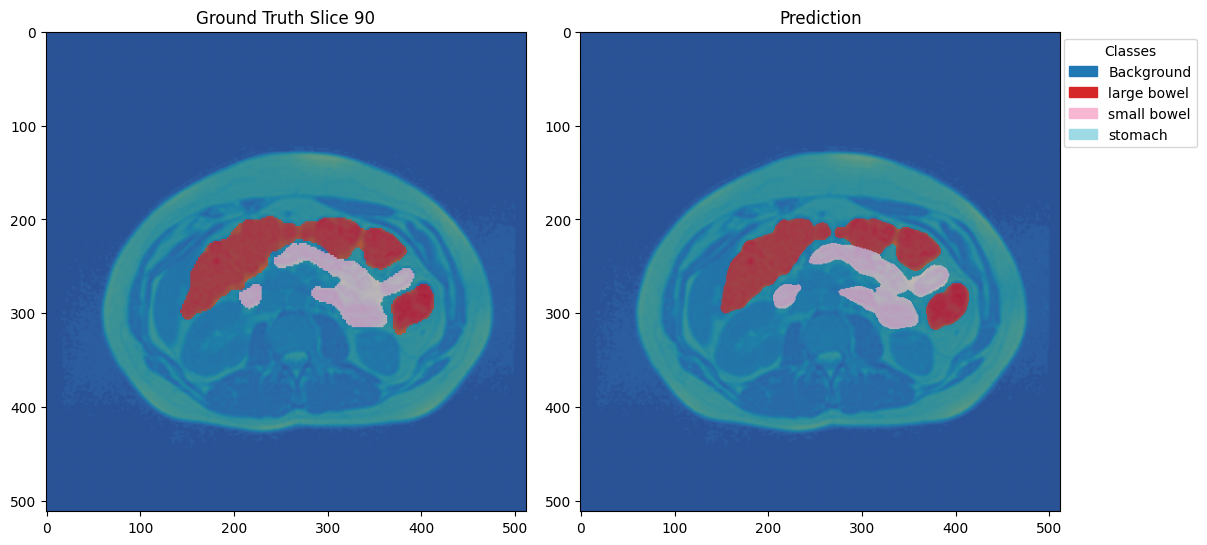

In [70]:
visualize(test_cases[0], "Test Patient 1", 90)

Test Patient 2: 100%|██████████| 1/1 [00:00<00:00, 12.31it/s]


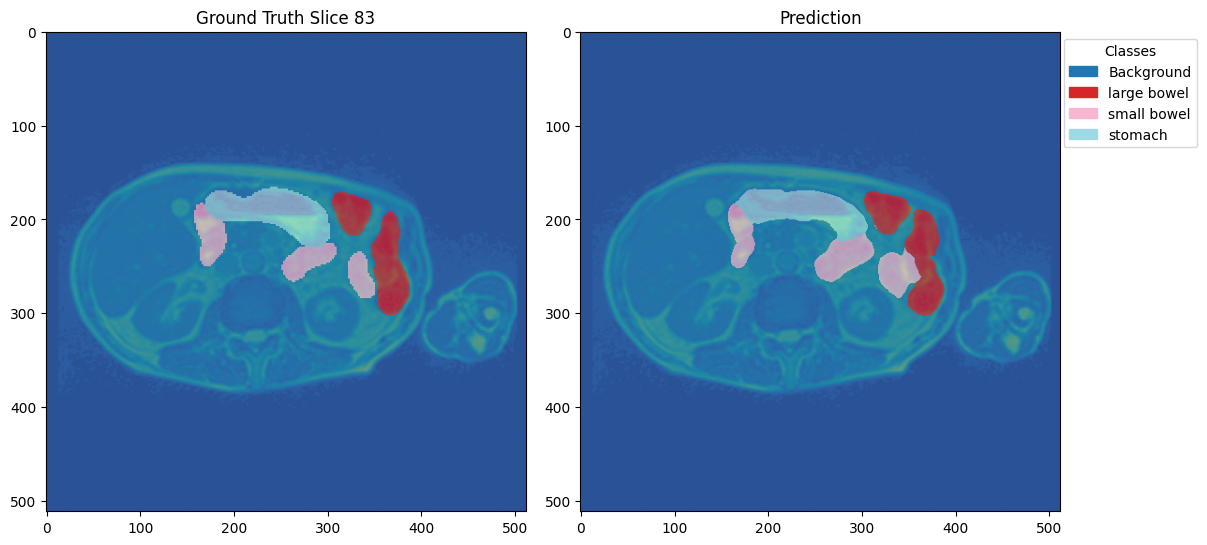

In [71]:
visualize(test_cases[1], "Test Patient 2", 83)

Test Patient 3: 100%|██████████| 1/1 [00:00<00:00, 11.06it/s]


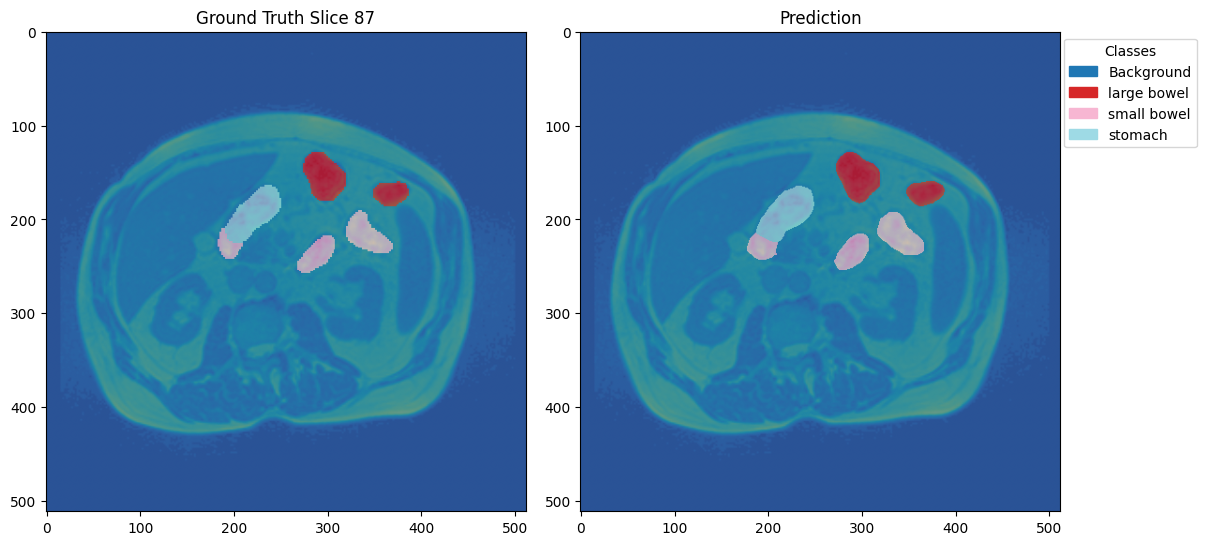

In [74]:
visualize(test_cases[2], "Test Patient 3", 87)

## Evaluation

#### Metrics used IoU: for mean IoU and class-wise IoU

In [ ]:
num_classes = 4
class_intersection = torch.zeros(num_classes)
class_union = torch.zeros(num_classes)

model.eval()
with torch.no_grad():
    progress_bar = tqdm(val_loader, desc="Per-class IoU")
    for batch in progress_bar:
        inputs = {k: v.to(device) for k, v in batch.items() if k != 'labels'}
        masks = batch['labels'].to(device)

        outputs = model(**inputs)
        logits = outputs.logits

        upsampled_logits = nn.functional.interpolate(
            logits,
            size=masks.shape[-2:],
            mode="bilinear",
            align_corners=False
        )

        preds = upsampled_logits.argmax(dim=1)

        for c in range(num_classes):
            pred_c = (preds == c)
            target_c = (masks == c)
            class_intersection[c] += (pred_c & target_c).sum().cpu()
            class_union[c] += (pred_c | target_c).sum().cpu()

print("\n" + "="*30)
print("Per-class IoU Results:")
print("="*30)
for c in range(num_classes):
    iou = (class_intersection[c] + 1e-6) / (class_union[c] + 1e-6)
    print(f"Class {c}: IoU = {iou:.4f}")

mean_iou = sum((class_intersection[c] + 1e-6) / (class_union[c] + 1e-6)
                for c in range(num_classes)) / num_classes
print(f"\nMean IoU: {mean_iou:.4f}")
print("="*30)

Per-class IoU: 100%|██████████| 64/64 [01:19<00:00,  1.24s/it]


Per-class IoU Results:
Class 0: IoU = 0.9876
Class 1: IoU = 0.6893
Class 2: IoU = 0.5508
Class 3: IoU = 0.7679

Mean IoU: 0.7489
